# Function Approximation

This is the notebook which creates Fig.5 and 6 of the paper.
It can be configured to estimate two different functions (f_1 and f_2) and train the model on a dataset of 20 points sampled from the respective functions. For the training of the model either simulated annealing (SA) or quantum annealing (QA) is employed. All paramters used in the paper hard hardcoded here and can be read directly from the source code.

In [1]:
from ising_learning_model import SimpleDataset, HiddenNodesInitialization, GammaInitialization, utils, QPUModel, AnnealingSettings, SimAnnealModel
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scienceplots
import pickle
plt.style.use('science')



In [2]:
fit_func = ["lin", "quad"][1]

In [15]:
# define linear and quadratic function
def f_1(x_1):
    return  1.2* (x_1 - 0.5) **  2  - 2

def f_2(x_1):
    return  2* (x_1 - 2) **  1  - 2

In [103]:
# Size is varied between 50 and 150
size = 150
num_samples = 20
solver = ["QPU", "SA"][1]

In [104]:
idx = "001"
name_short = f"{fit_func}_{size}_{num_samples}"
name = f"{name_short}_{solver}"

In [109]:
# create dataset
a = SimpleDataset()
if fit_func == "lin" and solver == "QPU" and size < 60:
    a.create_data_fun(f_2,num_samples,[[0,1]])
elif fit_func == "quad" and solver == "QPU" and size < 60:
    a.create_data_fun(f_1,num_samples,[[0,1]])
# or load dataset used in the paper
# a = pickle.load(open(f"data/{fit_func}_{size}_{num_samples}_QPU_dataset_{idx}.pkl", "rb"))
# print("loaded")

if solver == "QPU":
    print("QPU")
    profile = "default"
    # profile = "your_profile_name"
    m = QPUModel(size, profile=profile, num_reads=1)
else:
    print("SA")
    settings_anneal = AnnealingSettings()
    settings_anneal.beta_range = [1,10]
    settings_anneal.num_reads = 100
    settings_anneal.num_sweeps = 1000
    settings_anneal.sweeps_per_beta = 1
    m = SimAnnealModel(size, settings_anneal)

# init quantum annealer

# initialize hidden nodes with offset method from eq. 22.
m.settings.hidden_nodes_init = HiddenNodesInitialization("function")
m.settings.hidden_nodes_init.function = SimpleDataset.offset
if fit_func == "lin":
    m.settings.hidden_nodes_init.fun_args = [-1/size * 0.8]
elif fit_func == "quad":
    m.settings.hidden_nodes_init.fun_args = [-1/size]

# initialize Gamma matrix with zeros
m.settings.gamma_init = GammaInitialization("zeros")

SA


In [110]:
# set number of iterations
num_avg = 1
# set training settings
if solver == "QPU":
    if fit_func == "lin":
        m.settings.optim_steps = 200
        m.settings.learning_rate = 0.02
    elif fit_func == "quad":
        m.settings.optim_steps = 200
        m.settings.learning_rate = 0.25
    m.settings.mini_batch_size = num_samples
    m.settings.learning_rate_lmd = 0

    # setting initial values for epsilon and lambda
    m.offset_init_value = 'sample'
    if fit_func == "lin":
        m.lmd_init_value = -0.3 / (size / 50)
    elif fit_func == "quad":
        m.lmd_init_value = -0.05 / (size / 50)
else: # SA
    if fit_func == "lin":
        m.settings.optim_steps = 200
        m.settings.learning_rate = 0.02
    elif fit_func == "quad":
        m.settings.optim_steps = 200
        m.settings.learning_rate = 0.25
    m.settings.mini_batch_size = num_samples
    m.settings.learning_rate_lmd = 0

    # setting initial values for epsilon and lambda
    m.offset_init_value = 'sample'
    if fit_func == "lin":
        m.lmd_init_value = -0.3
    elif fit_func == "quad":
        m.lmd_init_value = -0.05

In [26]:
# training
results = pd.DataFrame(columns=['run_idx', "epoch", "idx_minibatch", "loss"])
for i in range(num_avg):
    print("Iteration: ", i)
    verbose = False
    save_samples = False
    if solver == "QPU":
        verbose = True
    r = m.train(a, save_params=True, save_samples=False, verbose=verbose)
    r.results['run_idx'] = i
    results = pd.concat([results, r.results], ignore_index=True)


Iteration:  0
offset: -9.28677331260871
epoch 0/200
	mini batch 0/1
		sampling in bulk using extra thread...
		sample 1/20
		sampled in 0.533707833 seconds
		sample 2/20
		sampled in 0.5579498329999999 seconds
		sample 3/20
		sampled in 0.5437008750000003 seconds
		sample 4/20
		sampled in 0.5566792499999997 seconds
		sample 5/20
		sampled in 0.5464667919999995 seconds
		sample 6/20
		sampled in 0.3423690000000006 seconds
		sample 7/20
		sampled in 0.4206614169999998 seconds
		sample 8/20
		sampled in 0.34052204099999983 seconds
		sample 9/20
		sampled in 0.3734955419999997 seconds
		sample 10/20
		sampled in 0.35683191700000005 seconds
		sample 11/20
		sampled in 0.5274214170000002 seconds
		sample 12/20
		sampled in 0.3545064170000005 seconds
		sample 13/20
		sampled in 0.35643116599999924 seconds
		sample 14/20
		sampled in 0.34842033299999997 seconds
		sample 15/20
		sampled in 0.35513316699999997 seconds
		sample 16/20
		sampled in 0.34102637499999844 seconds
		sample 17/20
		samp

In [27]:
results.to_csv(f"data/{name}_{idx}.csv")
r_test = m.test(a)
r_test.results_samples.to_csv(f"data/{name}_eval_{idx}.csv")
pickle.dump(a, open(f"data/{name}_dataset_{idx}.pkl", "wb"))
m._save_model(f"data/{name}_model_{idx}.pkl")



gamma 0/1
		sample 1/1
		sampled in 0.5056243750004796 seconds
		sample 1/1
		sampled in 0.5030253749991971 seconds
		sample 1/1
		sampled in 0.5965267499996116 seconds
		sample 1/1
		sampled in 0.525011584000822 seconds
		sample 1/1
		sampled in 0.4994804590005515 seconds
		sample 1/1
		sampled in 0.5147757079994335 seconds
		sample 1/1
		sampled in 0.5344905420006398 seconds
		sample 1/1
		sampled in 0.4753701249992446 seconds
		sample 1/1
		sampled in 0.5149380830007431 seconds
		sample 1/1
		sampled in 0.608372208000219 seconds
		sample 1/1
		sampled in 0.7103999159990053 seconds
		sample 1/1
		sampled in 0.60565383300127 seconds
		sample 1/1
		sampled in 0.5398411659989506 seconds
		sample 1/1
		sampled in 0.505741457998738 seconds
		sample 1/1
		sampled in 0.5428208749999612 seconds
		sample 1/1
		sampled in 0.5489605000002484 seconds
		sample 1/1
		sampled in 0.5002915000004577 seconds
		sample 1/1
		sampled in 0.532109625000885 seconds
		sample 1/1
		sampled in 0.53675195899995

# Plotting

This section just loads the previously computed data and creates the plots of Fig. 5 and 6.
To change between f_1 and f_2 simply change fit_func in the following from "lin" to "quad"

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scienceplots
import pickle
plt.style.use('science')

In [11]:

fit_func = ["lin", "quad"][0]
name_short = "quad_50_20"
idx = "001"

results_sa = pd.read_csv(f"data/{name_short}_SA_{idx}.csv")
results_qa = pd.read_csv(f"data/{name_short}_QPU_{idx}.csv")
results = pd.concat([results_sa, results_qa], keys=["SA", "QA 50"])
results['name'] = results.index.get_level_values(0)
results = results.reset_index(drop=True)


if fit_func == "quad":
    results_qa = pd.read_csv(f"data/quad_150_20_QPU_{idx}.csv")
else:
    results_qa = pd.read_csv(f"data/lin_150_20_QPU_{idx}.csv")
results_qa['name'] = ["QA 150"] * len(results_qa)

results = pd.concat([results, results_qa], ignore_index=True)

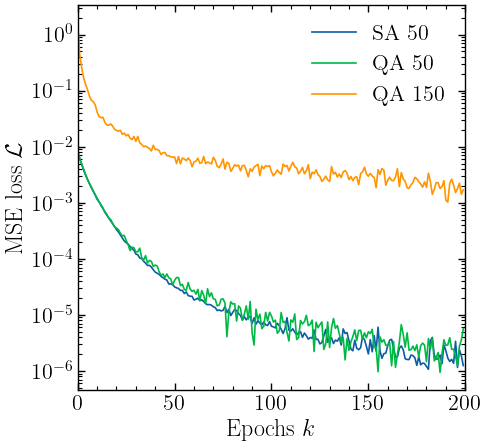

In [12]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.set_context("paper", font_scale=1.8)
sns.lineplot(data=results, x="epoch", y="loss",  hue="name",  ax=ax, legend="full")
sns.move_legend(ax, "upper right", ncol=1, title=None, bbox_to_anchor=(0.95, 0.95), frameon=False)
ax.set_yscale('log')
ax.set_ylabel(r"MSE loss $\mathcal{L}$")
ax.set_xlabel(r"Epochs $k$")
ax.set_xlim([0, 200])
# change legend names
handles, labels = ax.get_legend_handles_labels()
labels[0] = r"SA 50"
labels[1] = r"QA 50"
labels[2] = r"QA 150"
ax.legend(handles=handles, labels=labels)
plt.savefig("figures/loss_function_{}.pdf".format(fit_func), bbox_inches='tight')

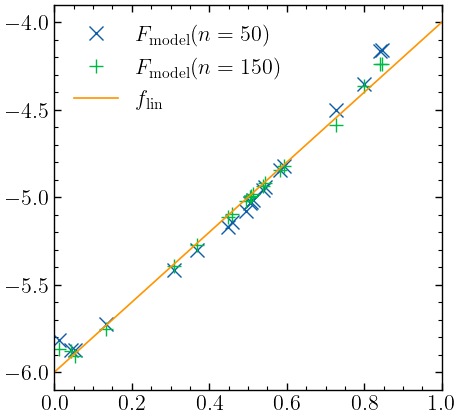

In [17]:
if fit_func == "quad":
    name = "quad_150_20_QPU"
    name2 = "quad_50_20_QPU"
else:
    name = "lin_150_20_QPU"
    name2 = "lin_50_20_QPU"
a = pickle.load(open(f"data/{name}_dataset_{idx}.pkl", "rb"))
results_eval_150 = pd.read_csv(f"data/{name}_eval_{idx}.csv")
results_eval_50 = pd.read_csv(f"data/{name2}_eval_{idx}.csv")
    
x = [e[0] for e in a.x]
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(x, results_eval_50["energy"], "x", label="model", markersize=10)
ax.plot(x, results_eval_150["energy"], "+", label="model", markersize=10)
x_lin = np.linspace(0,1,100)
if fit_func == "lin":
    ax.plot(x_lin, f_2(x_lin), label="$f_\mathrm{lin}$")
elif fit_func == "quad":
    ax.plot(x_lin, f_1(x_lin), label="$f_\mathrm{quad}$")
ax.legend()
# change legend names
handles, labels = ax.get_legend_handles_labels()
labels[0] = r"$F_\mathrm{model} (n=50)$"
labels[1] = r"$F_\mathrm{model} (n=150)$"
ax.legend(handles=handles, labels=labels)

plt.xlim([0,1])
plt.savefig("figures/fit_function_{}.pdf".format(fit_func), bbox_inches='tight')